# Notebook de modelagem e avaliação 

## Importação das bibliotecas

In [72]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

import joblib
import json

In [73]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

In [74]:
input_path_c_out = '../data/processed/arquivo-modelo.csv'
input_path_s_out = '../data/processed/arquivo_modelo_s_out.csv'

df = pd.read_csv(input_path_s_out)
df.tail()

,target,delta,return,return_1d,return_2d,return_3d,return_5d,momentum_aceel,momentum_consistency,vol_3d,...,target_lag2,target_lag3,target_lag4,target_lag5,target_lag6,target_lag7,close_lag1,close_lag3,close_lag5,close_lag7
2486,1.0,692.0,0.005072,0.005072,0.010531,0.007538,0.000920,-0.005459,1,0.004745,...,1.0,0.0,0.0,0.0,0.0,1.0,137128.0,135699.0,136236.0,137546.0
2487,0.0,672.0,0.004901,0.004901,0.009997,0.015483,0.011480,-0.005097,1,0.000271,...,1.0,1.0,0.0,0.0,0.0,0.0,137800.0,136436.0,136102.0,137002.0
2488,1.0,-587.0,-0.004260,-0.004260,0.000620,0.005695,0.008163,-0.004880,0,0.005339,...,1.0,1.0,1.0,0.0,0.0,0.0,137213.0,137128.0,135699.0,136236.0
2489,0.0,2043.0,0.014889,0.014889,0.010566,0.015518,0.026212,0.004323,1,0.009578,...,0.0,1.0,1.0,1.0,0.0,0.0,139256.0,137800.0,136436.0,136102.0
2490,0.0,-416.0,-0.002987,-0.002987,0.011857,0.007547,0.017620,-0.014845,0,0.010707,...,1.0,0.0,1.0,1.0,1.0,0.0,138840.0,137213.0,137128.0,135699.0


In [75]:
# Porcentagem da distribuição da tendência
df['target'].value_counts(normalize=True)

target
1.0    0.518667
0.0    0.481333
Name: proportion, dtype: float64

## Construção do modelo de classificação

In [76]:
X = df.iloc[:,1:]
y = df['target']

In [77]:
len(X.columns)

43

In [78]:
# Selecionando features para o modelo
mt_if_classif = SelectKBest(score_func=mutual_info_classif, k=22)

fit = mt_if_classif.fit(X ,y)

In [79]:
features = fit.transform(X)
print(features)

[[-1.76781484e-02 -1.76781484e-02 -5.77963601e-03 ...  1.00000000e+00
   4.85100000e+04  4.93010000e+04]
 [-5.56586271e-03 -5.56586271e-03 -2.31456169e-02 ...  0.00000000e+00
   4.82400000e+04  4.92340000e+04]
 [ 2.68034826e-02  2.68034826e-02  2.10884354e-02 ...  0.00000000e+00
   4.95330000e+04  4.87920000e+04]
 ...
 [-4.25979681e-03 -4.25979681e-03  6.19858818e-04 ...  1.00000000e+00
   1.37213000e+05  1.35699000e+05]
 [ 1.48892598e-02  1.48892598e-02  1.05660377e-02 ...  0.00000000e+00
   1.39256000e+05  1.36436000e+05]
 [-2.98730396e-03 -2.98730396e-03  1.18574771e-02 ...  1.00000000e+00
   1.38840000e+05  1.37128000e+05]]


In [80]:
cols = fit.get_support(indices=True)
df.iloc[:,cols].columns


Index(['delta', 'return', 'return_1d', 'return_3d', 'return_5d',
       'momentum_aceel', 'momentum_consistency', 'vol_10d', 'vol_regime',
       'open', 'low', 'rsi_9', 'bb_upper', 'bb_lower', 'bb_position', 'macd',
       'stoch_k', 'stoch_d', 'ema_10', 'target_lag1', 'target_lag7',
       'close_lag3'],
      dtype='object')

In [81]:
features_de_otimizacao = ['delta', 'return_1d', 'return_2d', 'return_3d', 'return_5d',
       'momentum_consistency', 'vol_regime', 'adx', 
        'macd', 'macd_signal', 'ema_10', 'z_score', 'bb_upper', 'bb_lower',
       'target_lag1', 'target_lag2', 'bb_position','target_lag3', 'target_lag7',
       'close_lag1', 'close_lag5']

# Separação das features
X, y = df[features_de_otimizacao], df['target']

# Separação de treino e teste
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2461, 21) (2461,) (30, 21) (30,)


In [82]:
# definindo modelos de classificação
seed = 1222
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=seed, n_jobs=-1))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=seed))
    ]),
    'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=seed),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=seed, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=seed, n_jobs=-1)
}

In [83]:
# treinando os modelos
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)

print("Todos os modelos foram treinados!")

Treinando Logistic Regression...
Treinando SVM...
Treinando Decision Tree...
Treinando Random Forest...
Treinando XGBoost...
Todos os modelos foram treinados!


## Avaliação do modelo

In [84]:
# comparando o desempenho dos modelos
performance = pd.DataFrame(
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    performance.loc[performance.shape[0]] = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }
performance.set_index("Model", inplace=True)
performance = performance.map(lambda x: f"{100 * x:2.2f} %")
performance.sort_values("F1-Score", ascending=False, inplace=True)

performance

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Random Forest,80.00 %,80.54 %,80.00 %,79.91 %
XGBoost,80.00 %,80.54 %,80.00 %,79.91 %
Logistic Regression,76.67 %,77.78 %,76.67 %,76.43 %
SVM,70.00 %,70.09 %,70.00 %,69.97 %
Decision Tree,63.33 %,63.89 %,63.33 %,62.96 %


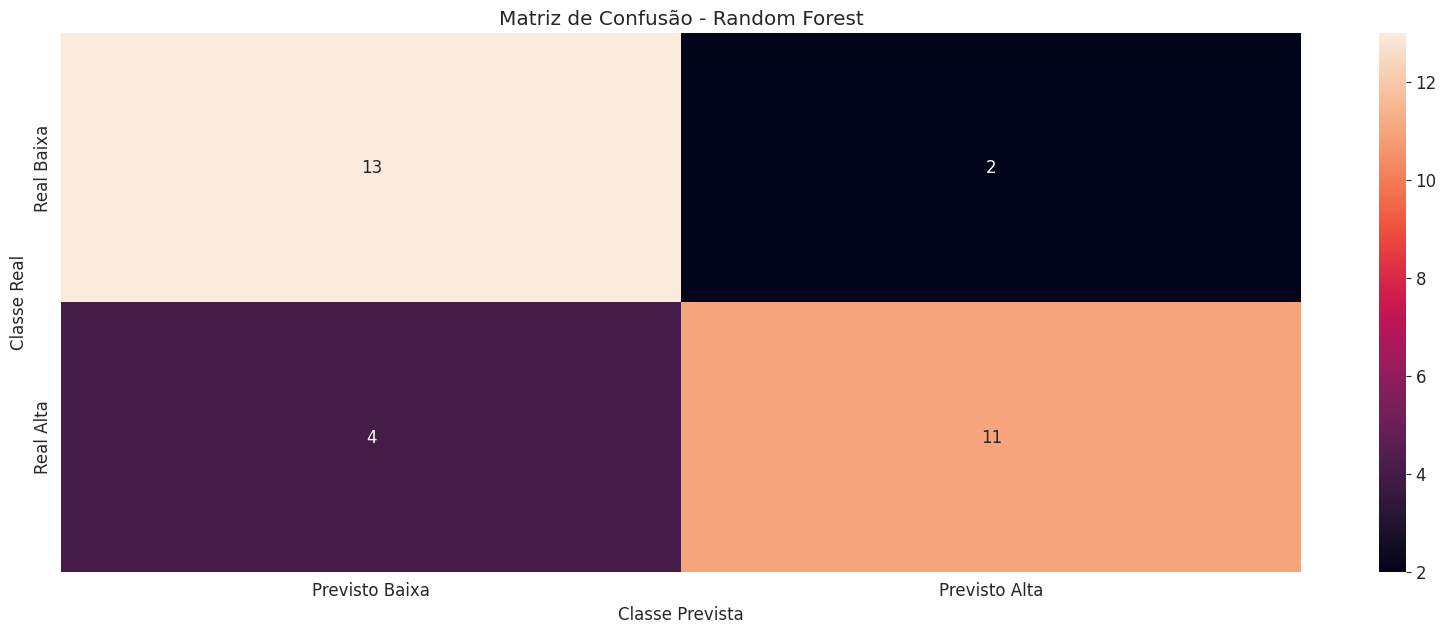

In [85]:
# matriz de confusão para o melhor modelo
best_model_name = performance.idxmax().iloc[0]
best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))

sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['Previsto Baixa', 'Previsto Alta'], 
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

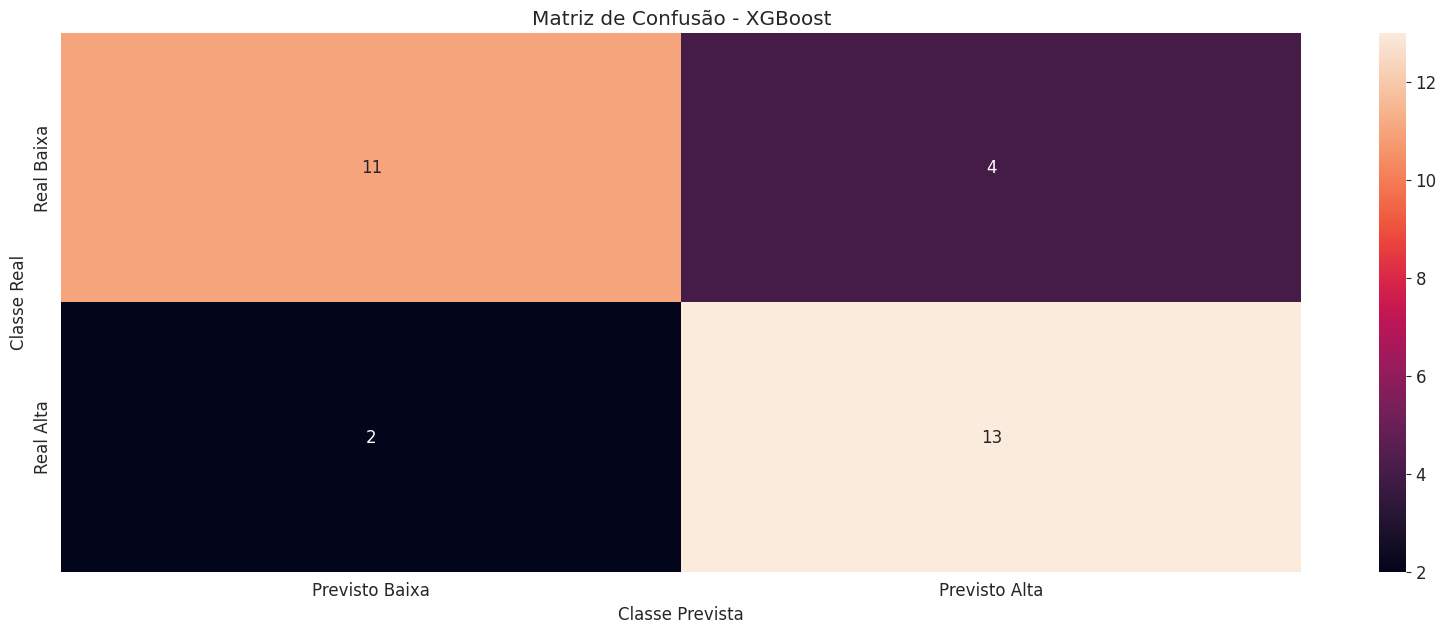

In [94]:
cm = confusion_matrix(y_test, models['XGBoost'].predict(X_test))

sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['Previsto Baixa', 'Previsto Alta'], 
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title(f'Matriz de Confusão - XGBoost')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

## Features mais relevantes

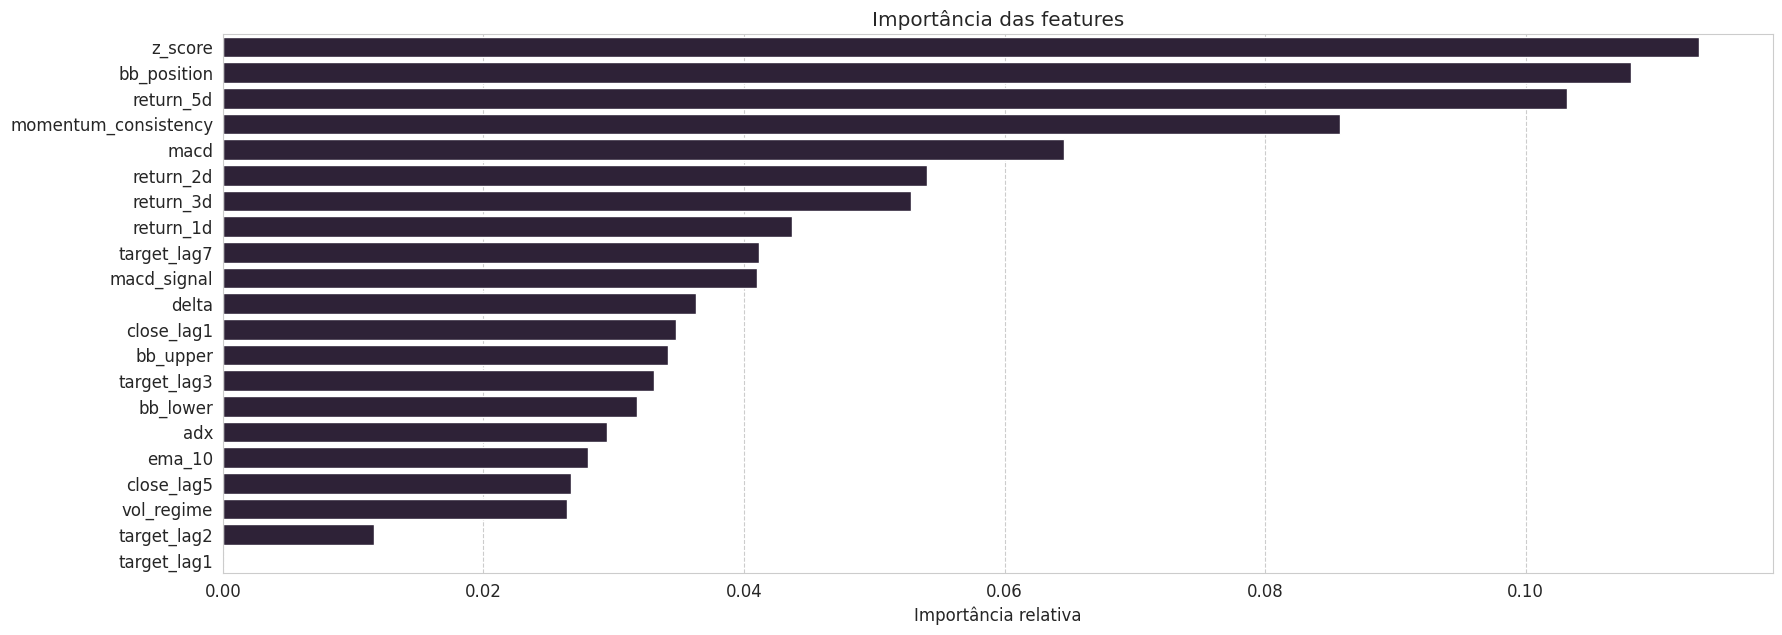

In [86]:
feature_importances = pd.Series(models['XGBoost'].feature_importances_, index=X_train.columns).sort_values(ascending=False).reset_index(name='importancia')

# plotando as features em ordem de importância para a previsão do modelo
sns.barplot(data=feature_importances, x='importancia', y='index')
plt.title('Importância das features')
plt.ylabel('')
plt.xlabel('Importância relativa')
plt.show()

In [87]:
# filtrar as features que atendem ao critério 95% 
feature_importances['acum'] = feature_importances['importancia'].cumsum()
best_features = feature_importances[feature_importances['acum'] < 0.96]['index'].sort_values().to_list()

print(f"Número de features original: {len(feature_importances)}")
print(f"Número de features após seleção com limiar de 95%: {len(best_features)}")
print("\nFeatures que serão mantidas para a otimização:")
print(list(best_features))

Número de features original: 21
Número de features após seleção com limiar de 95%: 17

Features que serão mantidas para a otimização:
['adx', 'bb_lower', 'bb_position', 'bb_upper', 'close_lag1', 'delta', 'ema_10', 'macd', 'macd_signal', 'momentum_consistency', 'return_1d', 'return_2d', 'return_3d', 'return_5d', 'target_lag3', 'target_lag7', 'z_score']


## Ajuste de hiperparâmetros com validação cruzada

A validação cruzada ajuda a garantir que o modelo não está sobreajustado aos dados de treinamento e terá um bom desempenho em dados novos. 

In [88]:
# hiperparâmetros que iremos testar
param_grid_xgb = {
    'n_estimators':[100, 150],              # Menos árvores
    'max_depth': [2, 5],                    # Árvores mais rasas
    'learning_rate': [0.03, 0.06],          # Learning rate menor
    'subsample': [0.5],                     # Entre 0.5 e 0.9
    'colsample_bytree': [0.5],              # Entre 0.5 e 0.9
    'colsample_bylevel': [ 0.5],            # Entre 0.5 e 0.9
    'reg_alpha': [0.1, 0.3, 0.6],           # Regularização L1 maior
    'reg_lambda': [0.5, 0.7],               # Regularização L2 maior
    'min_child_weight': [3, 5],             # Peso mínimo maior
    'gamma': [0.6, 1.2],                    # Poda mais agressiva
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=models['XGBoost'],
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

# análise dos resultados
print("Melhores parâmetros para o XGBoost: ", grid_search_xgb.best_params_)
print("Melhor acurácia na validação cruzada do XGBoost: {:.2%}".format(grid_search_xgb.best_score_))

Melhores parâmetros para o XGBoost:  {'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'gamma': 1.2, 'learning_rate': 0.06, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 0.7, 'subsample': 0.5}
Melhor acurácia na validação cruzada do XGBoost: 77.71%


In [89]:
# melhor XGB no conjunto de teste
best_xgb = grid_search_xgb.best_estimator_
pred_test_xgb = best_xgb.predict(X_test)

print("Relatório de classificação do XGBoost:\n")
print(classification_report(y_test, pred_test_xgb))

Relatório de classificação do XGBoost:

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83        15
         1.0       0.81      0.87      0.84        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30



In [90]:
# hiperparâmetros que iremos testar
param_grid_rf = {
    'n_estimators': [100, 200],          # Número de árvores
    'max_depth': [10, 20, None],         # Profundidade máxima de cada árvore
    'min_samples_leaf': [1, 5, 10],      # Número mínimo de amostras em uma folha
    'class_weight': ['balanced', None],  # Tratamento de desbalanceamento
    'max_features': ['sqrt', 'log2']     # Número de features a considerar em cada split
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=models['Random Forest'],
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

# análise dos resultados
print("Melhores parâmetros para o Random Forest: ", grid_search_rf.best_params_)
print("Melhor acurácia na validação cruzada do Random Forest: {:.2%}".format(grid_search_rf.best_score_))

Melhores parâmetros para o Random Forest:  {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Melhor acurácia na validação cruzada do Random Forest: 75.37%


In [91]:
# melhor Random Forest no conjunto de teste
best_rf = grid_search_rf.best_estimator_
pred_test_rf = best_rf.predict(X_test)

print("Relatório de classificação do Random Forest:\n")
print(classification_report(y_test, pred_test_rf))

Relatório de classificação do Random Forest:

              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73        15
         1.0       0.73      0.73      0.73        15

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30



## Exportação do modelo

In [92]:
# salvar o melhor modelo
model_filename = f"../models/{best_model_name.replace(' ', '_')}.joblib"
joblib.dump(best_xgb, model_filename)

['../models/Random_Forest.joblib']

In [93]:
# salvar as métricas de performance
report_dict = classification_report(y_test, pred_test_xgb, output_dict=True)
metrics_filename = f"../reports/metrics_{best_model_name.replace(' ', '_')}.json"

with open(metrics_filename, 'w', encoding='utf-8') as f:
    json.dump(report_dict, f, ensure_ascii=False, indent=4)